# Group-Level Epoch-Based Decoding Accuracy Aggregation Script

This script computes trial-level decoding accuracies for a P300 paradigm across a range of epoch counts. It uses cross-validation (with 4 folds) and evaluates the effect of increasing the number of epochs (or “epoch bins”) on trial-level performance. The key outputs are the group-level mean accuracies and their standard errors, aggregated by each epoch bin. Finally, the results are saved to an NPZ file.



---

## Workflow Overview

1. **Initialize Data Structures:**
   - `results_decoding`: A dictionary to store per-subject, per-fold accuracies along with aggregated group-level mean and standard error (SE) values.
   - `group_accuracies_per_epoch`: A helper dictionary used to gather accuracy values across subjects for each epoch count.

2. **Define Epoch Bins:**
   - `epoch_bins` is created using `np.linspace(5, 80, 16)`, generating 16 bins (from 5 to 80 epochs) which represent the number of epochs used for trial-level inference.

3. **Processing Each Subject:**

 **Note:** This script is adapted for files that contain NaNs. If a subject has too few epochs to be integrated, it will be skipped. If a trial has too few epochs, the loop across epoch_counts will take the min(epoch_count, n_available_epochs) for integration for the following epoch_counts. An early plateau in the plots indicate this happening. Relevant for subj W and X.
     -
   - For each subject (iterating over a list of subjects), the script:
     - Loads the pre-saved feature file (NPZ) that contains:
       - `X`: EEG data (trials × channels × samples).
       - `y`: Labels indicating the cued side per trial.
       - `z`: Target information (trials × epochs × sides).
     - Splits the trials into 4 folds for cross-validation.
     - For each fold:
       - Separates the training and testing sets.
       - Reshapes the training data into epochs and extracts corresponding labels for LDA training. (A balancing function is optionally called to balance the classes.)
       - Similarly, reshapes the testing data for evaluation.
       - **Model Training:** An LDA classifier (with Ledoit-Wolf covariance estimator) is trained on the training epochs.
       - **Evaluation:** For every testing trial, the script computes the decision function scores from LDA over all epochs. Then, for each defined epoch bin (i.e. using only the first *n* epochs), it:
         - Computes correlations between the LDA scores and the left and right target values.
         - Assigns a trial-level decision based on which correlation is stronger.
         - Records a correctness indicator (1 if the decision matches the cued side; 0 otherwise).
       - The fold's trial accuracy is computed as the average of the correctness indicators for each epoch bin.
     - For each subject, the fold accuracies are averaged to produce subject-level accuracy per epoch bin.

4. **Group-Level Aggregation:**
   - The script collects subject-level accuracies for each epoch bin into `group_accuracies_per_epoch`.
   - For each epoch bin, the group-level mean accuracy and standard error (SE) are computed and stored in the `results_decoding` dictionary under the keys `"mean_accuracies"` and `"se_accuracies"`.

5. **Saving the Results:**
   - The epoch bins, group mean accuracies, and SE values are converted to NumPy arrays.
   - These arrays are saved in an NPZ file (e.g., `"covert_lda_p300_decC_results.npz"`)

---


In [1]:
import os
from os.path import join
import numpy as np
from scipy.stats import pearsonr
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.covariance import LedoitWolf
from sklearn.covariance import OAS
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

wd = r'C:\Users\Radovan\OneDrive\Radboud\Studentships\Jordy Thielen\root'
os.chdir(wd)
data_dir = join(wd, "data")
experiment_dir = join(data_dir, "experiment")
files_dir = join(experiment_dir, 'files')
sourcedata_dir = join(experiment_dir, 'sourcedata')
derivatives_dir = join(join(experiment_dir, 'derivatives'))
analysis_dir = join(data_dir, "analysis")
p300_dir = join(analysis_dir, "p300")
decoding_results_dir = join(p300_dir, "decoding_results") 
plots_dir = join(p300_dir, "plots")
features_dir = join(plots_dir, "features")

subjects = ["VPpdia","VPpdib", "VPpdic", "VPpdid", "VPpdie", "VPpdif", "VPpdig","VPpdih", "VPpdii", "VPpdij",
            "VPpdik", "VPpdil", "VPpdim", "VPpdin", "VPpdio", "VPpdip", "VPpdiq", "VPpdir", "VPpdis", "VPpdit",
            "VPpdiu", "VPpdiv", "VPpdiw", "VPpdix","VPpdiy", "VPpdiz", "VPpdiza", "VPpdizb", "VPpdizc"]

In [2]:
def balance_classes(X, y, ratio_0_to_1=1.0):
    
    """
    Sub-select X and y based on a specified ratio of 0s to 1s, keeping the original order.

    Parameters:
    X (numpy.ndarray): Feature matrix of shape (n_samples, n_features).
    y (numpy.ndarray): Label vector of shape (n_samples,).
    ratio_0_to_1 (float): The desired ratio of 0s to 1s in the balanced dataset.

    Returns:
    X_balanced, y_balanced: Sub-selected feature matrix and label vector.
    """
    # Step 1: Identify indices of 0s and 1s
    indices_0 = np.where(y == 0)[0]
    indices_1 = np.where(y == 1)[0]
    
    # Step 2: Calculate the number of samples to select for each class
    num_1s = len(indices_1)
    # If not enough nontarget epochs survived for given ratio, take maximum available
    num_0s = min(len(indices_0), int(num_1s * ratio_0_to_1))
    
    # Step 3: Randomly sample the desired number of 0s and 1s
    selected_indices_0 = np.random.choice(indices_0, num_0s, replace=False)
    selected_indices_1 = np.random.choice(indices_1, num_1s, replace=False)
    
    # Step 4: Combine selected indices and sort to preserve original order
    balanced_indices = np.sort(np.concatenate([selected_indices_0, selected_indices_1]))
    
    # Step 5: Sub-select X and y based on the balanced indices
    X_balanced = X[balanced_indices]
    y_balanced = y[balanced_indices]
    
    return X_balanced, y_balanced

In [3]:
def filter_valid_epochs(X, y, z=None, return_mask=False):
    """
    Filters out epochs where either the features in X or the labels in y contain NaN values.
    Optionally, if a z array is provided, it is filtered similarly.
    
    Parameters:
        X (np.ndarray): A 2D numpy array with shape (n_epochs, n_features).
        y (np.ndarray): A 1D numpy array with shape (n_epochs,).
        z (np.ndarray, optional): An array that will be filtered using the same mask.
        return_mask (bool, optional): If True, the boolean mask used for filtering is returned.
    
    Returns:
        filtered_X (np.ndarray): X with only rows that have no NaN values.
        filtered_y (np.ndarray): y with only entries corresponding to valid epochs.
        filtered_z (np.ndarray or None): Filtered z array (if provided) or None.
        mask (np.ndarray, optional): The boolean mask of valid epochs; only returned if return_mask=True.
    """
    # Create a mask for valid labels and features
    valid_label_mask = ~np.isnan(y)
    valid_feature_mask = ~np.isnan(X).any(axis=1)
    combined_mask = valid_label_mask & valid_feature_mask

    # Apply the mask to X and y
    filtered_X = X[combined_mask]
    filtered_y = y[combined_mask]
    
    if z is not None:
        filtered_z = z[combined_mask]
    else:
        filtered_z = None

    if return_mask:
        return filtered_X, filtered_y, filtered_z, combined_mask
    else:
        return filtered_X, filtered_y, filtered_z

## Decoding curve 

Results saved to C:\Users\Radovan\OneDrive\Radboud\Studentships\Jordy Thielen\root\data\analysis\p300\decoding_results\covert_lda_p300_decC_generalization_results_wo_baselinecorrect.npz


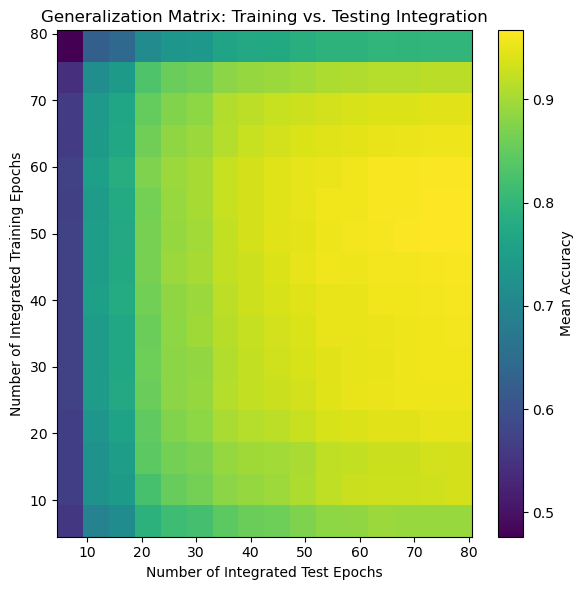

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.covariance import LedoitWolf

# -- Parameters --
do_balance_classes = True
ratio_0_to_1 = 6
discard_threshold = 5  # minimum valid epochs required for a trial

# Directories and subjects are assumed to be defined:
# subjects, derivatives_dir, decoding_results_dir

# Define integration bins for both training and testing (using the same bins here)
train_epoch_bins = np.linspace(5, 80, 16, dtype=int)
test_epoch_bins  = np.linspace(5, 80, 16, dtype=int)

# Data storage structure: we'll store per-subject, per-fold generalization matrices.
results_decoding = {
    "subjects": {},         # subject -> fold -> train_bin -> test_bin -> accuracy
    "mean_accuracies": {},  # (train_epoch, test_epoch) -> group-level mean accuracy
    "se_accuracies": {}     # (train_epoch, test_epoch) -> group-level standard error
}

# Helper: to accumulate subject-level accuracies across subjects for each (train, test) combination.
group_accuracies = {}  # keys: (train_epoch, test_epoch) -> list of subject-level accuracies

# Log discarded epochs (for information)
discarded_epochs_info = {}

# Iterate over subjects
for subject in subjects:
    file_dir = os.path.join(derivatives_dir, 'features', "p300", f"sub-{subject}")
    file_path = os.path.join(file_dir, f"sub-{subject}_task-covert_p300_features_wo_baselinecorrect.npz")
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        continue

    # Load data from NPZ file
    npz_data = np.load(file_path)
    X = npz_data['X']  # shape: [n_trials, n_epochs, n_channels, n_features]
    y = npz_data['y']  # shape: [n_trials,]
    z = npz_data['z']  # shape: [n_trials, n_epochs, 2] (left vs right targets)

    # Set up 4-fold cross-validation
    n_folds = 4
    n_trials = int(X.shape[0] / n_folds)
    folds = np.repeat(np.arange(n_folds), n_trials)

    # Initialize per-subject storage
    results_decoding["subjects"][subject] = {fold: {} for fold in range(n_folds)}
    
    # Log number of epochs with NaN in features (for debugging)
    num_discarded_epochs = np.sum(np.isnan(X).any(axis=(2, 3)))
    discarded_epochs_info[subject] = num_discarded_epochs

    # Process each fold
    for i_fold in range(n_folds):
        # Split into train and test sets
        X_trn_trials = X[folds != i_fold]
        y_trn_trials = y[folds != i_fold]
        z_trn_trials = z[folds != i_fold]
        
        X_tst_trials = X[folds == i_fold]
        y_tst_trials = y[folds == i_fold]
        z_tst_trials = z[folds == i_fold]
        
        # Prepare a structure to store results for this fold:
        # For each training integration level, we will store a dictionary over test integration levels.
        fold_results = {train_bin: {test_bin: [] for test_bin in test_epoch_bins} 
                        for train_bin in train_epoch_bins}
        
        # ----- TRAINING: Loop over different training integration levels -----
        for train_bin in train_epoch_bins:
            X_train_samples = []
            y_train_samples = []
            # Loop over training trials
            for t in range(len(y_trn_trials)):
                # Reshape trial data: each trial is [n_epochs, n_channels, n_features]
                X_trial = X_trn_trials[t].reshape(X_trn_trials[t].shape[0], -1)
                # Get corresponding target values from z: use the cued side (given by y_trn_trials[t])
                # Here, each trial yields a label per epoch (as in your original approach)
                y_trial = z_trn_trials[t, :, y_trn_trials[t]]
                
                # Filter out epochs with NaNs
                # Assumed to return: X_valid, y_valid, _ (we ignore the third output)
                X_valid, y_valid, _ = filter_valid_epochs(X_trial, y_trial)
                # Only include trial if enough valid epochs are available for the current training integration level
                if len(X_valid) < train_bin:
                    continue
                # Use the first train_bin valid epochs for training (do not average; treat them as independent samples)
                X_sub = X_valid[:train_bin]
                y_sub = y_valid[:train_bin]
                X_train_samples.append(X_sub)
                y_train_samples.append(y_sub)
            
            # If no training data is available for this train_bin, assign 0 accuracy for all test bins
            if len(X_train_samples) == 0:
                for test_bin in test_epoch_bins:
                    fold_results[train_bin][test_bin] = 0
                continue
            
            # Concatenate training data across trials
            X_train_concat = np.concatenate(X_train_samples, axis=0)
            y_train_concat = np.concatenate(y_train_samples, axis=0)
            
            # Optionally balance classes
            if do_balance_classes:
                X_train_concat, y_train_concat = balance_classes(X_train_concat, y_train_concat, ratio_0_to_1=ratio_0_to_1)
            
            # Train the LDA classifier
            lda = LDA(solver="lsqr", covariance_estimator=LedoitWolf())
            lda.fit(X_train_concat, y_train_concat)
            
            # ----- TESTING: Loop over test trials and test integration levels -----
            # We'll accumulate accuracy per test integration level in a temporary structure.
            test_results = {test_bin: [] for test_bin in test_epoch_bins}
            for t in range(len(y_tst_trials)):
                # Reshape test trial: shape [n_epochs, n_channels*n_features]
                X_trial = X_tst_trials[t].reshape(X_tst_trials[t].shape[0], -1)
                cued_side = y_tst_trials[t]
                
                # For test, extract full target info: left & right target signals
                z_trial = z_tst_trials[t]  # shape: [n_epochs, 2]
                left_targets = z_trial[:, 0]
                right_targets = z_trial[:, 1]
                cued_targets = z_trial[:, cued_side]
                
                # Filter out invalid epochs; for test we pass both cued and full z for later use
                X_valid, cued_valid, z_valid = filter_valid_epochs(X_trial, cued_targets, z_trial)
                
                # If not enough valid epochs, count trial as incorrect for all test integration levels
                if len(X_valid) < discard_threshold:
                    for test_bin in test_epoch_bins:
                        test_results[test_bin].append(0)
                    continue
                
                # For each test integration level, use the first N valid epochs
                for test_bin in test_epoch_bins:
                    actual_test_count = min(test_bin, len(X_valid))
                    X_subset = X_valid[:actual_test_count]
                    left_sub = z_valid[:actual_test_count, 0]
                    right_sub = z_valid[:actual_test_count, 1]
                    
                    # Obtain decision function scores for each epoch in the subset
                    epoch_scores = lda.decision_function(X_subset)
                    
                    # Compare correlations with left and right target signals
                    corr_left, _ = pearsonr(epoch_scores, left_sub)
                    corr_right, _ = pearsonr(epoch_scores, right_sub)
                    decision = 0 if corr_left > corr_right else 1
                    correct = int(decision == cued_side)
                    test_results[test_bin].append(correct)
            
            # Compute mean accuracy for each test integration level for the current train_bin
            for test_bin in test_epoch_bins:
                fold_results[train_bin][test_bin] = np.mean(test_results[test_bin])
        
        # Save fold_results for the current fold
        results_decoding["subjects"][subject][i_fold] = fold_results

    # ----- Aggregate across folds for this subject -----
    # For each (train_bin, test_bin) combination, average accuracy over folds.
    subject_matrix = {}
    for train_bin in train_epoch_bins:
        subject_matrix[train_bin] = {}
        for test_bin in test_epoch_bins:
            fold_vals = [results_decoding["subjects"][subject][f][train_bin][test_bin] 
                         for f in range(n_folds)]
            subject_matrix[train_bin][test_bin] = np.mean(fold_vals)
            # Accumulate for group-level analysis
            key = (train_bin, test_bin)
            if key not in group_accuracies:
                group_accuracies[key] = []
            group_accuracies[key].append(subject_matrix[train_bin][test_bin])
    
    # Optionally, you can store subject_matrix as the subject-level result (if needed)
    results_decoding["subjects"][subject]["subject_level"] = subject_matrix

# ----- Group-Level Aggregation -----
# Build matrices for group-level mean accuracies and standard errors.
mean_acc_matrix = np.zeros((len(train_epoch_bins), len(test_epoch_bins)))
se_acc_matrix   = np.zeros((len(train_epoch_bins), len(test_epoch_bins)))

for i, train_bin in enumerate(train_epoch_bins):
    for j, test_bin in enumerate(test_epoch_bins):
        key = (train_bin, test_bin)
        subj_accs = group_accuracies.get(key, [])
        if len(subj_accs) > 0:
            group_mean = np.mean(subj_accs)
            group_std  = np.std(subj_accs)
            group_se   = group_std / np.sqrt(len(subj_accs))
        else:
            group_mean = 0
            group_se = 0
        mean_acc_matrix[i, j] = group_mean
        se_acc_matrix[i, j]   = group_se
        results_decoding["mean_accuracies"][key] = group_mean
        results_decoding["se_accuracies"][key]   = group_se

# Save results to NPZ file
save_path = os.path.join(decoding_results_dir, "covert_lda_p300_decC_generalization_results_wo_baselinecorrect.npz")
np.savez(
    save_path,
    train_epoch_bins=train_epoch_bins,
    test_epoch_bins=test_epoch_bins,
    mean_accuracies=mean_acc_matrix,
    se_accuracies=se_acc_matrix
)
print(f"Results saved to {save_path}")

# ----- Plotting -----
# Create a heatmap of the group-level mean accuracies.
plt.figure(figsize=(6, 6))
im = plt.imshow(mean_acc_matrix, aspect='auto', origin='lower',
                extent=[test_epoch_bins[0]-0.5, test_epoch_bins[-1]+0.5, 
                        train_epoch_bins[0]-0.5, train_epoch_bins[-1]+0.5])
plt.colorbar(im, label="Mean Accuracy")
plt.xlabel("Number of Integrated Test Epochs")
plt.ylabel("Number of Integrated Training Epochs")
plt.title("Generalization Matrix: Training vs. Testing Integration")
plt.tight_layout()
plt.show()


## Plot subject resolved Decoding Curve

Plot saved to:
  C:\Users\Radovan\OneDrive\Radboud\Studentships\Jordy Thielen\root\data\analysis\p300\plots\decoding\covert_lda_p300_decC_results_perSubj_wo_baselinecorrect.png


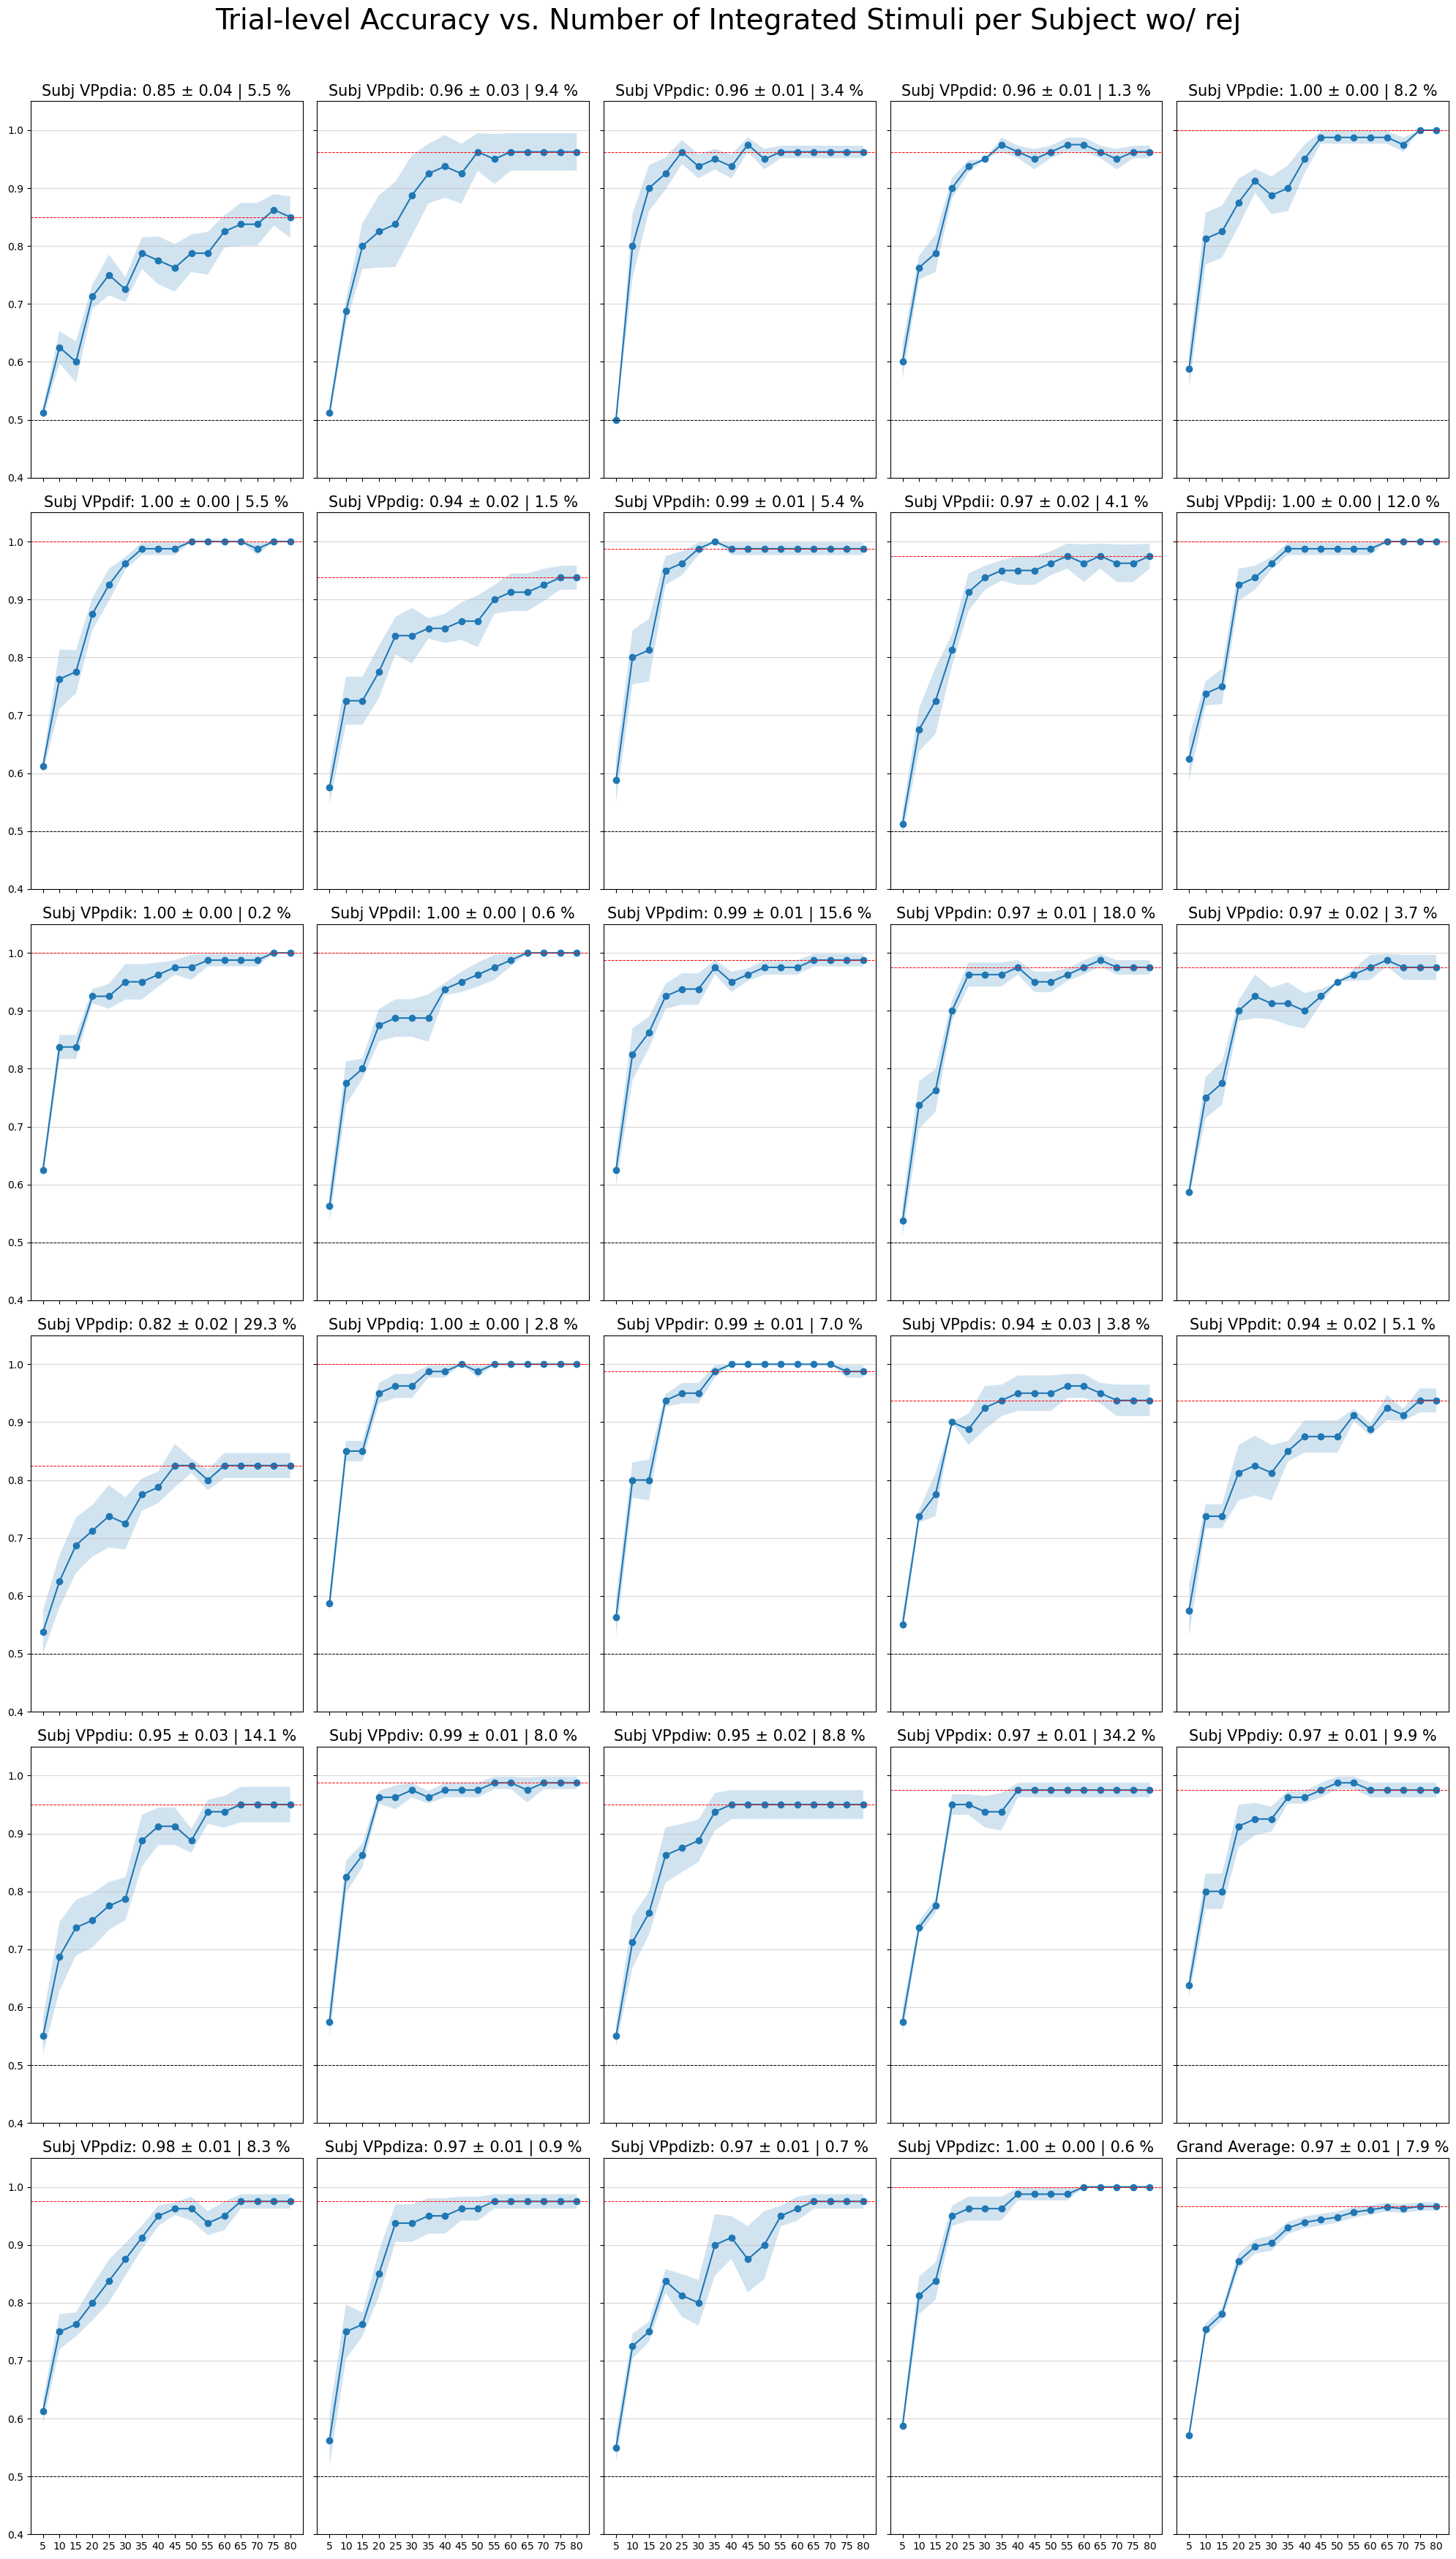

In [ ]:
import matplotlib.pyplot as plt

# Collect subject IDs
subject_ids = list(results_decoding["subjects"].keys())

n_subjects = len(subject_ids)

# Grab the epoch bins from the keys of 'mean_accuracies' (sorted for a nice left-to-right plot)
epoch_bins = sorted(results_decoding["mean_accuracies"].keys())

# Arrange subplots (up to 5 columns, adapt rows accordingly)
n_cols = min(5, n_subjects)
n_rows = (n_subjects + 1 + n_cols - 1) // n_cols  # +1 for the "Grand Average" subplot
fig, axes = plt.subplots(
    nrows=n_rows, ncols=n_cols,
    figsize=(4 * n_cols, 6 * n_rows),
    sharey=True
)
axes = np.ravel(axes)  # Flatten so we can index them in a 1D fashion

# Plot each subject
for i, subject in enumerate(subject_ids):
    ax = axes[i]
    subject_data = results_decoding["subjects"][subject]
    # subject_data is a dict like:
    #   {fold_idx: {epoch_count -> accuracy_float}, ...}

    # collect fold-level accuracies to compute subject-level mean & SE
    subject_mean_accuracies = []
    subject_se_accuracies = []

    # Loop over each epoch_count in ascending order
    for epoch_count in epoch_bins:
        fold_accuracies = []
        for fold_idx, fold_dict in subject_data.items():
            # fold_dict is a dict {epoch_count -> accuracy_float}
            fold_accuracies.append(fold_dict[epoch_count])

        fold_accuracies = np.array(fold_accuracies)
        mean_acc = np.mean(fold_accuracies)
        se_acc = np.std(fold_accuracies) / np.sqrt(len(fold_accuracies))

        subject_mean_accuracies.append(mean_acc)
        subject_se_accuracies.append(se_acc)

    # Convert lists to arrays
    subject_mean_accuracies = np.array(subject_mean_accuracies)
    subject_se_accuracies = np.array(subject_se_accuracies)

    # Compute upper/lower bounds for shading
    lower_bound = subject_mean_accuracies - subject_se_accuracies
    upper_bound = subject_mean_accuracies + subject_se_accuracies

    # Plot
    ax.plot(epoch_bins, subject_mean_accuracies, '-o', label=f"Subject {subject}")
    ax.fill_between(epoch_bins, lower_bound, upper_bound, alpha=0.2)

    # Show final-epoch summary in the title
    ax.set_title(
        f"Subj {subject}: {subject_mean_accuracies[-1]:.2f} ± {subject_se_accuracies[-1]:.2f} | {(discarded_epochs_info[subject] / 6400 * 100):.1f} %",
        fontsize=15
    )
    ax.grid(alpha=0.5, axis='y')
    # Horizontal reference lines
    ax.axhline(y=subject_mean_accuracies[-1], color='red', linestyle='--', linewidth=0.7)
    ax.axhline(y=0.5, color='k', linestyle='--', linewidth=0.7)  # chance line
    
    ax.set_ylim(0.4, 1.0)

    # Show y-ticks only in the first column
    if i % n_cols == 0:
        ax.set_yticks(np.round(np.arange(0.4, 1.1, 0.1),1 ))
    else:
        ax.set_yticklabels(np.round(np.arange(0.4, 1.1, 0.1),1 ))

    # X-ticks only for the last row of subplots
    if i >= (n_rows - 1) * n_cols: 
        ax.set_xticks(epoch_bins)
    else:
        ax.set_xticks(epoch_bins)
        ax.set_xticklabels([])

# plot "Grand Average"

ax_grand = axes[n_subjects]

grand_mean_accuracies = np.array([
    results_decoding["mean_accuracies"][ec] for ec in epoch_bins
])
grand_se_accuracies = np.array([
    results_decoding["se_accuracies"][ec] for ec in epoch_bins
])

grand_lower_bound = grand_mean_accuracies - grand_se_accuracies
grand_upper_bound = grand_mean_accuracies + grand_se_accuracies

ax_grand.plot(epoch_bins, grand_mean_accuracies, '-o', label="Grand Average")
ax_grand.fill_between(epoch_bins, grand_lower_bound, grand_upper_bound, alpha=0.2)

ax_grand.set_title(
    f"Grand Average: {grand_mean_accuracies[-1]:.2f} ± {grand_se_accuracies[-1]:.2f} | {(np.mean(list(discarded_epochs_info.values())) / 6400 * 100):.1f} %",
    fontsize=15
)
ax_grand.grid(alpha=0.5, axis='y')
ax_grand.axhline(y=0.5, color='k', linestyle='--', linewidth=0.7)
ax_grand.axhline(y=grand_mean_accuracies[-1], color='red', linestyle='--', linewidth=0.7)
ax_grand.set_ylim(0.4, 1.05)
ax_grand.set_yticks(np.round(np.arange(0.4, 1.05, 0.1),1 ))
ax_grand.set_xticks(epoch_bins)


fig.suptitle("Trial-level Accuracy vs. Number of Integrated Stimuli per Subject wo/ rej", 
             y=0.97, fontsize=28)
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Save
task = "covert"
save_dir = os.path.join(plots_dir, 'decoding')
os.makedirs(save_dir, exist_ok=True)

save_path_png = join(save_dir, f"{task}_lda_p300_decC_results_perSubj_wo_baselinecorrect.png")
save_path_svg = join(save_dir, f"{task}_lda_p300_decC_results_perSubj_wo_baselinecorrect.svg")
plt.savefig(save_path_png, dpi=300)
plt.savefig(save_path_svg, dpi=300)

print(f"Plot saved to:\n  {save_path_png}")
plt.show()


## Plot only Grand Average

Accuracy at full epoch integration: 0.97 ± 0.01


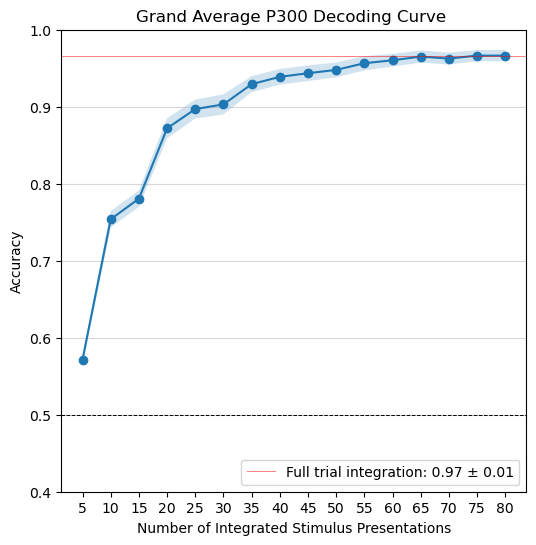

In [ ]:
import matplotlib.pyplot as plt

# Extract epoch bins (sorted)
epoch_bins = sorted(results_decoding["mean_accuracies"].keys())

# Build arrays for plotting
mean_acc_array = np.array([results_decoding["mean_accuracies"][eb] for eb in epoch_bins])
se_acc_array   = np.array([results_decoding["se_accuracies"][eb]   for eb in epoch_bins])

# Create a single figure and axis
plt.figure(figsize=(6, 6))

# Plot the mean accuracy
plt.plot(epoch_bins, mean_acc_array, '-o', label='')

# Fill between mean ± SE
lower_bound = mean_acc_array - se_acc_array
upper_bound = mean_acc_array + se_acc_array
plt.fill_between(epoch_bins, lower_bound, upper_bound, alpha=0.2)

# horizontal reference lines
plt.axhline(y=0.5, color='k', linestyle='--', linewidth=0.7)  # chance line
plt.axhline(y=1.0, color='k', linestyle='--', linewidth=0.7)  # perfect accuracy
plt.axhline(y=mean_acc_array[-1], color='red', linestyle='-', linewidth=0.7, alpha = 0.5, label = f'Full trial integration: {mean_acc_array[-1]:.2f} ± {se_acc_array[-1]:.2f}')
# Axis labels, title, and limits
plt.xlabel("Number of Integrated Stimulus Presentations", fontsize=10)
plt.ylabel("Accuracy", fontsize=10)
plt.ylim(0.4, 1.0)
plt.xticks(epoch_bins)
plt.title("Grand Average P300 Decoding Curve ", fontsize=12)
plt.grid(alpha=0.5, axis='y')
plt.legend(loc='lower right')

# Save the figure

task = "covert"
save_dir = os.path.join(plots_dir, 'decoding')
os.makedirs(save_dir, exist_ok=True)


plt.savefig(join(save_dir, f"{task}_lda_p300_decC_results_GA_wo_rej.png"), dpi=300)
plt.savefig(join(save_dir, f"{task}_lda_p300_decC_results_GA_wo_rej.svg"), dpi=300)
plt.plot()
print (f"Accuracy at full epoch integration: {mean_acc_array[-1]:.2f} ± {se_acc_array[-1]:.2f}")


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert

# Sampling parameters
fs = 200.0          # Sampling frequency (Hz)
T  = 1.0            # Duration (seconds)
N  = int(fs * T)    # Number of samples
t  = np.linspace(0, T, N, endpoint=False)  # Time array

# Construct a test signal x(t)
x = np.cos(2*np.pi*5*t) + 0.5*np.cos(2*np.pi*10*t)


In [2]:
z = hilbert(x)           # This is the complex analytic signal: x(t) + j * x̂(t)
x_hat = np.imag(z)       # The imaginary part is the Hilbert transform x̂(t)


In [3]:
inst_amp = np.abs(z)
inst_phase = np.angle(z)


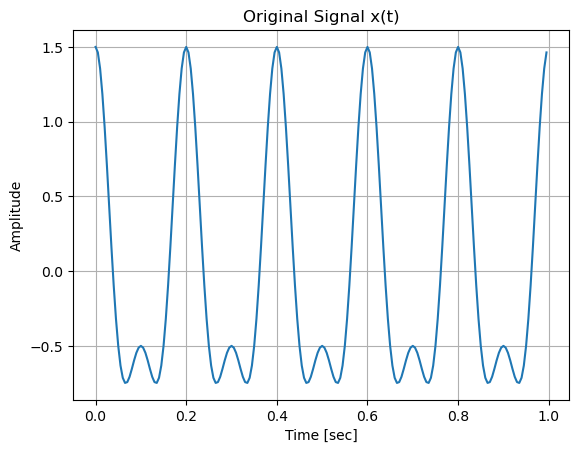

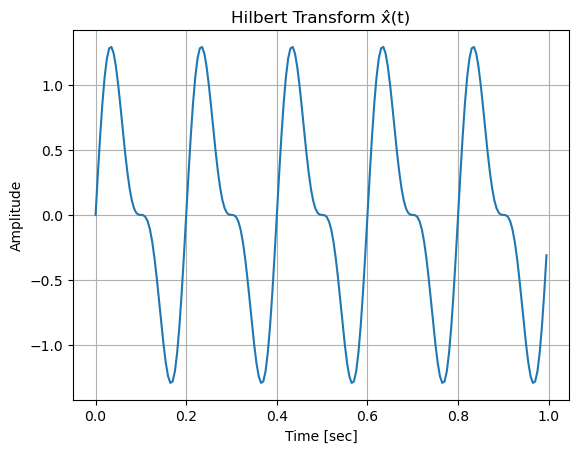

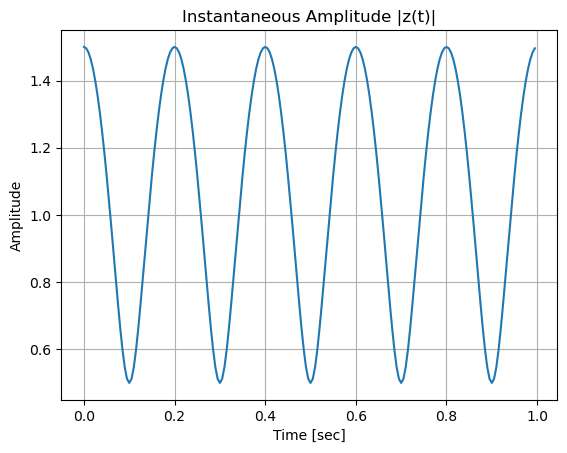

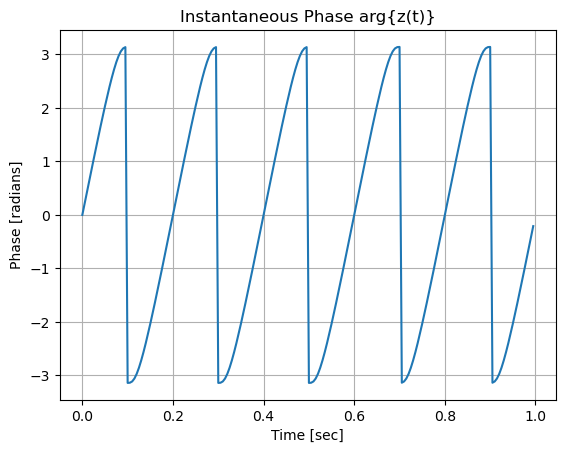

In [4]:
# 1) Plot the original signal x(t)
plt.figure()
plt.plot(t, x)
plt.title("Original Signal x(t)")
plt.xlabel("Time [sec]")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

# 2) Plot the Hilbert transform x̂(t)
plt.figure()
plt.plot(t, x_hat)
plt.title("Hilbert Transform x̂(t)")
plt.xlabel("Time [sec]")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

# 3) Plot the instantaneous amplitude A(t)
plt.figure()
plt.plot(t, inst_amp)
plt.title("Instantaneous Amplitude |z(t)|")
plt.xlabel("Time [sec]")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

# 4) Plot the instantaneous phase φ(t)
plt.figure()
plt.plot(t, inst_phase)
plt.title("Instantaneous Phase arg{z(t)}")
plt.xlabel("Time [sec]")
plt.ylabel("Phase [radians]")
plt.grid(True)
plt.show()
